# Predicting Housing Prices

## Introduction

For this project, my goal is to determine the price of a house in King County (WA) using data mining techniques.

Scenario: I am planning on purchasing a new home and would like to determine how much I should pay for a house in King County that meets my criteria:

   1. 2000 sqft_living
   2. 3000 sqft_lot
   3. 1500 sqft_above
   4. 500 sqft_basement
   5. 47.77 lat
   6. -122.20 long
   7. 0 waterfront
   8. 1 view
   9. 4 bedrooms
   10. 2 bathrooms
   11. 2 floors
   12. 4 condition
   13. 9 grade
   14. not built recently
   15. is not renovated
   16. sold in December
   
These are features you might find in a house near my neighborhood.

## The data set

I will be using a public domain data set available from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). The data includes all home sales in King County, WA from May 2014 to May 2015. The outcome variable is $price$ and there are 20 features.

**Explanation of features**

Most of the feature variables are self explanatory, but some are not.
   - $waterfront$: value of 1 if the house is overlooking the waterfront, 0 otherwise
   - $view$: value from 0 to 4, where 0 is a house with a poor view
   - $condition$: value from 1 to 5, where 1 is a house in poor condition
   - $grade$: value from 1 to 13, where 1 is a house built with a poor level of construction and design
   - $sqft\_living15$: interior living space for the nearest 15 neighbors 


___

## Loading the libraries

In [24]:
library(tidyverse)
library(caret)
library(GGally)
library(lubridate)
library(reshape2)
library(scales)

Warning message:
"package 'lubridate' was built under R version 3.6.3"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'reshape2' was built under R version 3.6.3"
Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Warning message:
"package 'scales' was built under R version 3.6.3"
Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor



## Load and Prepare the Data Set

In [171]:
file = 'kc_house_data.csv'
house = read_csv(file)

set.seed(2436)

#factor and log10 transform variables
house <- house %>%
    mutate(waterfront_fac = as.factor(waterfront),
          view_fac = as.factor(view),
          bedrooms_fac = as.factor(bedrooms),
          bathrooms_fac = as.factor(bathrooms),
          floors_fac = as.factor(floors),
          condition_fac = as.factor(condition),
          grade_fac = as.factor(grade),
          price_log = log10(price),
          sqft_above_log = log10(sqft_above),
          sqft_living_log = log10(sqft_living),
          sqft_basement_log = log10(sqft_basement + 1),
          sqft_lot_log = log10(sqft_lot))

#remove unuseful variables
#lat and long provides finer detail than zip
house <- house %>%
    select(-id, -zipcode)

#33 bed for 640k is probably an entry error
#same with 0 bed/bath, but if they actually exist, they would likely
#be priced lower. So, just remove those that are priced high.
house <- house %>%
    filter(bedrooms != 33,
          !(bedrooms == 0 & bathrooms == 0 & price > 1000000))

summary(house)
str(house)

Parsed with column specification:
cols(
  .default = col_double(),
  id = col_character(),
  date = col_datetime(format = "")
)
See spec(...) for full column specifications.


      date                         price            bedrooms    
 Min.   :2014-05-02 00:00:00   Min.   :  75000   Min.   : 0.00  
 1st Qu.:2014-07-22 00:00:00   1st Qu.: 321612   1st Qu.: 3.00  
 Median :2014-10-16 00:00:00   Median : 450000   Median : 3.00  
 Mean   :2014-10-29 05:04:11   Mean   : 540023   Mean   : 3.37  
 3rd Qu.:2015-02-17 00:00:00   3rd Qu.: 645000   3rd Qu.: 4.00  
 Max.   :2015-05-27 00:00:00   Max.   :7700000   Max.   :11.00  
                                                                
   bathrooms      sqft_living       sqft_lot           floors     
 Min.   :0.000   Min.   :  290   Min.   :    520   Min.   :1.000  
 1st Qu.:1.750   1st Qu.: 1426   1st Qu.:   5040   1st Qu.:1.000  
 Median :2.250   Median : 1910   Median :   7619   Median :1.500  
 Mean   :2.115   Mean   : 2080   Mean   :  15107   Mean   :1.494  
 3rd Qu.:2.500   3rd Qu.: 2550   3rd Qu.:  10688   3rd Qu.:2.000  
 Max.   :8.000   Max.   :13540   Max.   :1651359   Max.   :3.500  
           

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	21610 obs. of  31 variables:
 $ date             : POSIXct, format: "2014-10-13" "2014-12-09" ...
 $ price            : num  221900 538000 180000 604000 510000 ...
 $ bedrooms         : num  3 3 2 4 3 4 3 3 3 3 ...
 $ bathrooms        : num  1 2.25 1 3 2 4.5 2.25 1.5 1 2.5 ...
 $ sqft_living      : num  1180 2570 770 1960 1680 ...
 $ sqft_lot         : num  5650 7242 10000 5000 8080 ...
 $ floors           : num  1 2 1 1 1 1 2 1 1 2 ...
 $ waterfront       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ view             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ condition        : num  3 3 3 5 3 3 3 3 3 3 ...
 $ grade            : num  7 7 6 7 8 11 7 7 7 7 ...
 $ sqft_above       : num  1180 2170 770 1050 1680 ...
 $ sqft_basement    : num  0 400 0 910 0 1530 0 0 730 0 ...
 $ yr_built         : num  1955 1951 1933 1965 1987 ...
 $ yr_renovated     : num  0 1991 0 0 0 ...
 $ lat              : num  47.5 47.7 47.7 47.5 47.6 ...
 $ long             : num 

From the summary() function, notice that there are many variables with an unusual amount of 0's - this suggests the distribution may be skewed.

## Visualizations

### Continuous variables

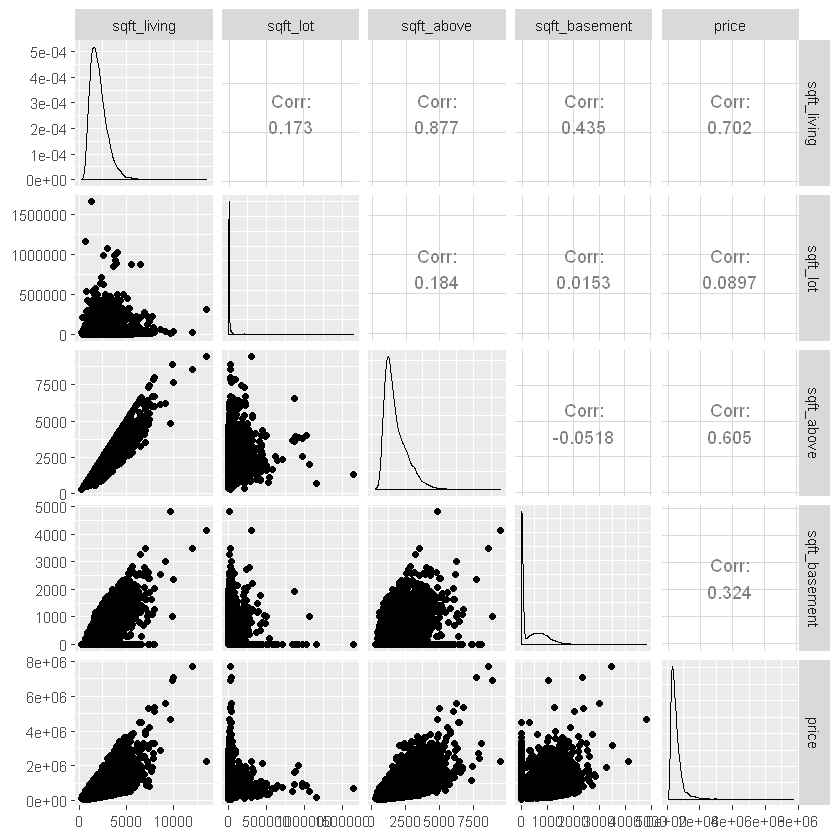

In [172]:
ggpairs(house[, c(5, 6, 12, 13, 2)])

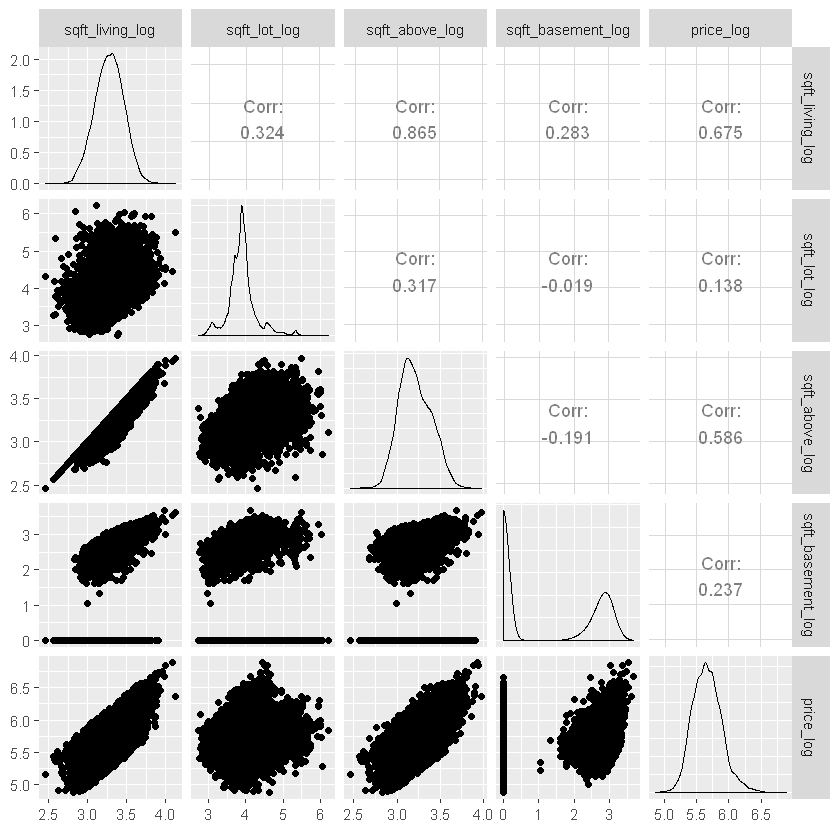

In [173]:
#look at the effects of the log transformations
ggpairs(house[, c(29, 31, 28, 30, 27)])

Looking at the visuals, there are a couple interesting patterns.

   1. High correlation with $price$
   2. High correlation between independent variables
   3. Highly skewed distributions
        - This was addressed using a log transformation 

### Discrete variables

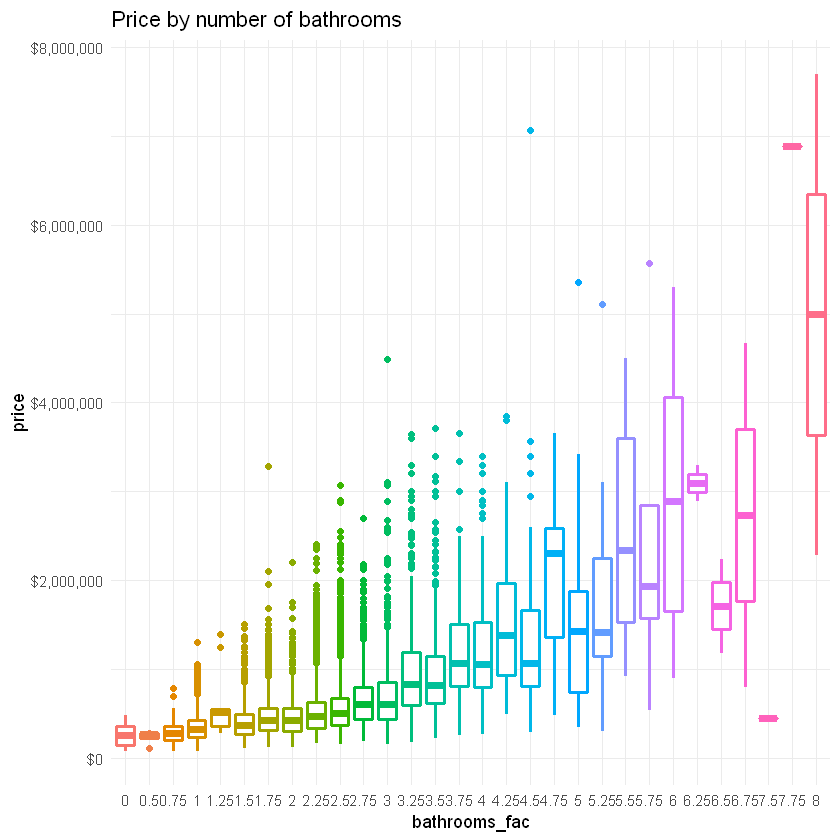

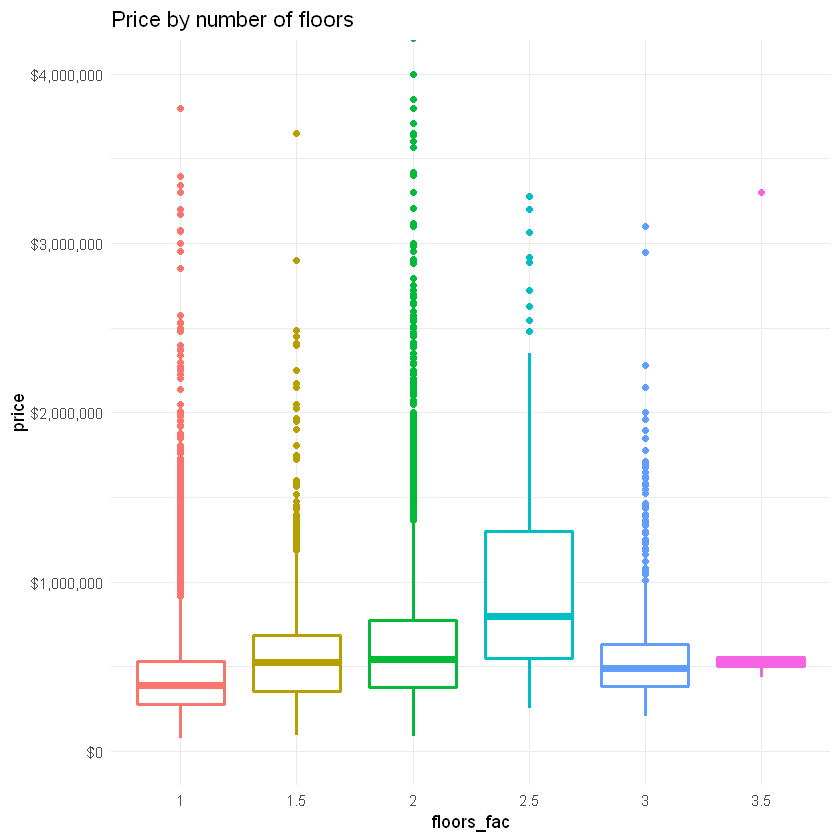

In [174]:
#bedrooms
house %>%
    ggplot(aes(x = bathrooms_fac, y = price, color = bathrooms_fac)) +
    geom_boxplot(size = 1) +
    scale_y_continuous(label = label_dollar()) +
    ggtitle(label = "Price by number of bathrooms") +
    theme_minimal() +
    guides(color = FALSE)

#floors
house %>%
    ggplot(aes(x = floors_fac, y = price, color = floors_fac)) +
    geom_boxplot(size = 1) +
    coord_cartesian(ylim = c(0, 4000000)) +
    scale_y_continuous(labels = label_dollar()) +
    ggtitle(label = "Price by number of floors") +
    theme_minimal() +
    guides(color = FALSE)

As the number of $bathrooms$ increases, so does $price$. This trend is also seen by number of $floors$, but its effect on $price$ is not as pronounced. 

**Hypothesis**

Square foot living is a major predictor of price. Intuitively, this is logical since price per sq. ft. is a common metric used for home pricing evaluations.

## Feature Engineering

To try and increase performance of my models, I will use feature engineering. 

The first variable I will create is called $is\_build\_recently$, where a house built after 1975 is a recently built house.

For the second, I will create a feature called $is\_renovated$ from $yr\_renovated$. This is to lessen the effect of the 0's, which represents an unrenovated house.

Lastly, although there is only one year of data, a $month$ variable may be useful for season price adjustments.


   no   yes 
10933 10677 


Before 2000  After 2000          No 
        456         458       20696 


   1    2    3    4    5    6    7    8    9   10   11   12 
 978 1250 1875 2231 2414 2177 2211 1940 1774 1878 1411 1471 

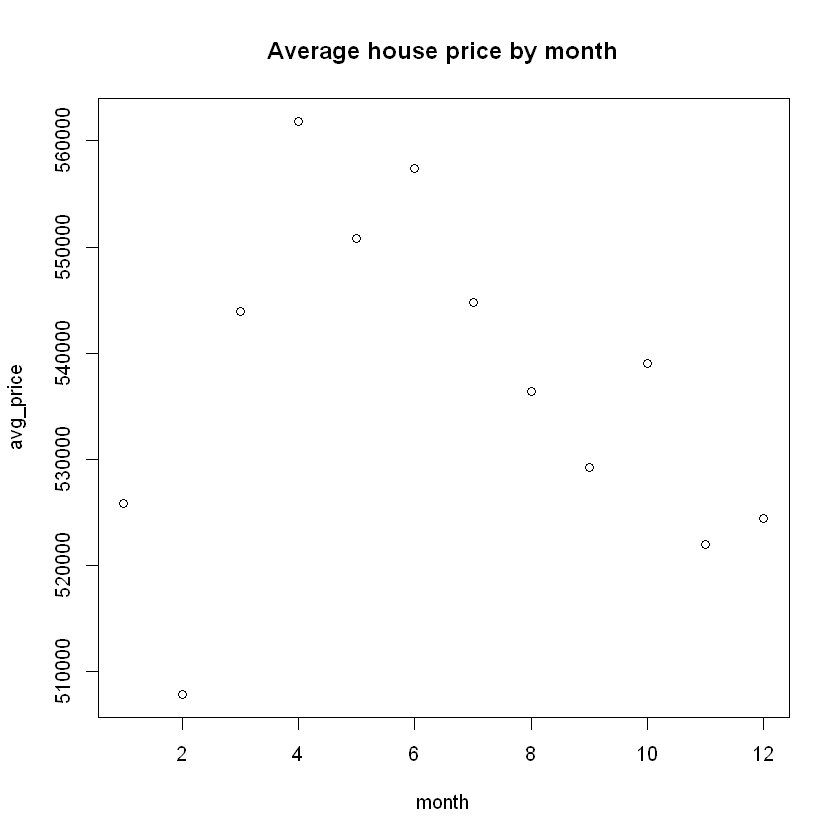

In [177]:
#is_built_recently
house$is_built_recently <- ifelse(house$yr_built > 1975, 'yes', 'no') %>% as.factor()
table(house$is_built_recently)

#is_renovated
house <- house %>%
    mutate(is_renovated = case_when(
        yr_renovated == 0 ~ 'No',
        yr_renovated >= 0 & yr_renovated < 2000 ~ "Before 2000",
        yr_renovated >= 2000 ~ 'After 2000') %>% 
           factor(levels = c('Before 2000', 'After 2000', 'No')))
table(house$is_renovated)

#month
house$date <- as_datetime(house$date)
house$month <- month(house$date)
table(house$month)

house %>% 
    group_by(month) %>% 
    summarise(avg_price = mean(price)) %>% 
        plot(main = "Average house price by month")

house <- house %>%
    select(-yr_built, -yr_renovated, -date)

There does seem to be a season pattern: prices peak during the spring-summer months and are lowest in the winter.

## Variable Selection

To decide which variables will be included in the model, I will:

   1. Evaluate variable correlations
   2. Remove highly correlated independent variables
   3. Evaluate variable significance
   4. Remove variables with low significance

In [178]:
#high correlation will be defined as above 0.70
house_cor <- house %>% select(1:19)

correlationMatrix <- cor(select_if(house_cor, is.numeric))
cor_melt <- arrange(melt(correlationMatrix), desc(value))
cor_melt %>%
    filter(value > 0.70, value != 1, row_number() %% 2 == 1)

cor_melt %>%
    filter(Var1 == "price", value > 0.50, value != 1)


Var1,Var2,value
sqft_above,sqft_living,0.8765397
grade,sqft_living,0.7626435
sqft_living15,sqft_living,0.7563012
sqft_above,grade,0.7558538
sqft_living,bathrooms,0.7556146
sqft_living15,sqft_above,0.7316863
sqft_lot15,sqft_lot,0.7185560
sqft_living15,grade,0.7130264
sqft_living,price,0.7019567


Var1,Var2,value
price,sqft_living,0.7019567
price,grade,0.6674508
price,sqft_above,0.6054470
price,sqft_living15,0.5852946
price,bathrooms,0.5258635


We see that sqft_living15 and sqft_lot15 are colinear to features of similar names. Also, they are highly correlated with price, so they will be removed before running data mining algorithms.

In [179]:
tree_df <- house %>%
    select(price, bedrooms_fac, bathrooms_fac, sqft_living, sqft_lot,
          floors_fac, condition_fac, grade_fac, sqft_above, sqft_basement,
          lat, long, waterfront_fac, view_fac, is_built_recently, is_renovated, month)

tree_model <- train(price ~ ., data = tree_df,
                   method = "rpart",
                   trControl = trainControl(method = "cv", number = 3))
var_imp <- varImp(tree_model)
var_imp

house <- house %>%
    select(-sqft_living15, -sqft_lot15)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

rpart variable importance

  only 20 most important variables shown (out of 76)

                  Overall
sqft_living        100.00
lat                 76.00
sqft_above          67.65
grade_fac10         39.54
grade_fac9          23.77
grade_fac11         23.68
bathrooms_fac2.25    0.00
bathrooms_fac2       0.00
grade_fac12          0.00
bathrooms_fac0.75    0.00
bedrooms_fac6        0.00
view_fac1            0.00
bathrooms_fac6.25    0.00
bathrooms_fac6.5     0.00
bathrooms_fac1.25    0.00
bedrooms_fac3        0.00
bathrooms_fac6.75    0.00
bedrooms_fac4        0.00
bathrooms_fac2.75    0.00
sqft_basement        0.00

Using a decision tree to view variable importance, we see that our hypothesis is correct - $sqft\_living$ is indeed a major predictor of price. This is followed by $lat$, $sqft\_above$, and high $grade$. However, I decided to keep all the variables since I want to account for the impact, however small, of things such as number of floors.

## Model Selection

I will consider 7 different models: linear regression, forward regression, backward regression, ridge regression, lasso regression, random forest, and bagged trees.

### Create training and testing sets

In [180]:
in_train <- createDataPartition(y = house$price,
                               p = 0.80,
                               list = FALSE)
house_train <- house[in_train, ]
house_test <- house[-in_train, ]

### Pre-process

In [182]:
preprocessing_steps = preProcess(select(house, -price, -price_log),
                                method = c('center', 'scale', 'nzv'))

house_train_proc = predict(preprocessing_steps, newdata = house_train)
house_test_proc = predict(preprocessing_steps, newdata = house_test)

**Linear Regression**

In [193]:
#use processed data, with transformed vars
#vars chosen after exploratory analysis due to good properties with price
#in order to optimize performance and try to prevent overfitting
house_lm <- house_train_proc %>%
    select(price_log, sqft_living_log, sqft_above_log, bedrooms, bathrooms,
          grade, lat, long, condition, is_built_recently, is_renovated, month)

trControl = trainControl(method = 'cv', number = 3)

lm_model <- train(price_log ~ .,
                 data = house_lm,
                 method = 'lm',
                 metric = 'RMSE',
                 trControl = trControl)
summary(lm_model)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59440 -0.07644 -0.00140  0.07055  0.58665 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               5.7356173  0.0061653 930.313  < 2e-16 ***
sqft_living_log           0.0776900  0.0022778  34.107  < 2e-16 ***
sqft_above_log            0.0113594  0.0020154   5.636 1.76e-08 ***
bedrooms                 -0.0170917  0.0012184 -14.027  < 2e-16 ***
bathrooms                 0.0218616  0.0015811  13.827  < 2e-16 ***
grade                     0.0959107  0.0015163  63.252  < 2e-16 ***
lat                       0.0840897  0.0009365  89.794  < 2e-16 ***
long                     -0.0082216  0.0010239  -8.030 1.04e-15 ***
condition                 0.0219014  0.0009823  22.296  < 2e-16 ***
is_built_recentlyyes     -0.0606102  0.0025887 -23.413  < 2e-16 ***
`is_renovatedAfter 2000`  0.0393216  0.0087413   4.498 6.89e-06 ***
is_renovatedNo     

**Forward Regression**

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"5  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"6  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"3  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


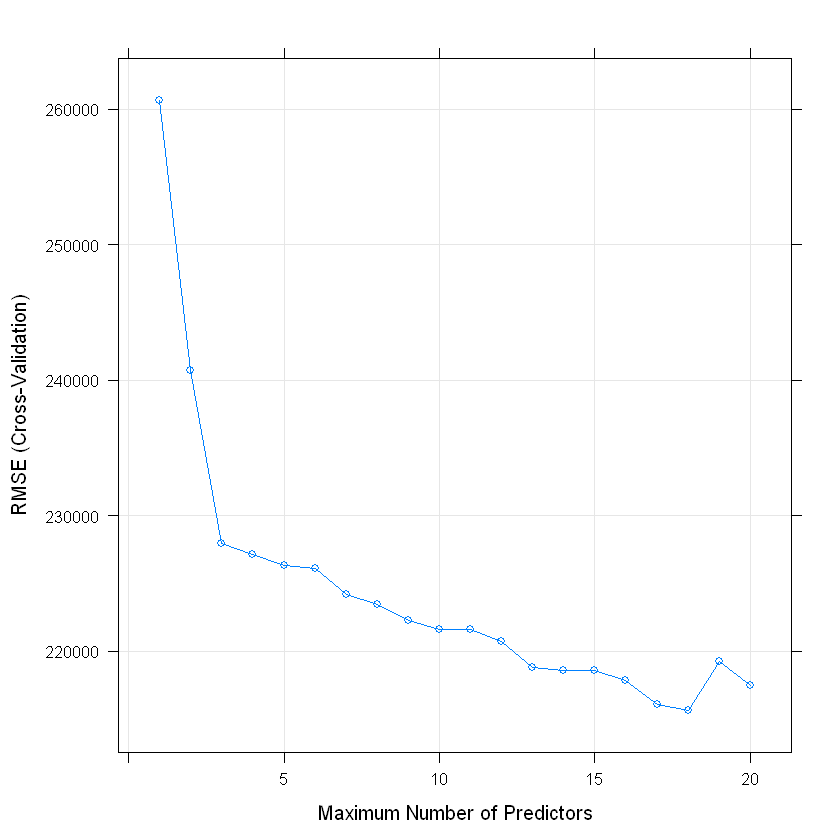

In [184]:
#use processed data, with factored vars
house_reg <- house_train_proc %>%
    select(1, 4, 5, 9:18, 23:25) 

forward_model <- train(price ~ ., data = house_reg,
                      method = "leapForward",
                      tuneGrid = expand.grid(nvmax = 1:20),
                      trControl = trControl)
plot(forward_model)

**Backward Regression**

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"3  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"5  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"6  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


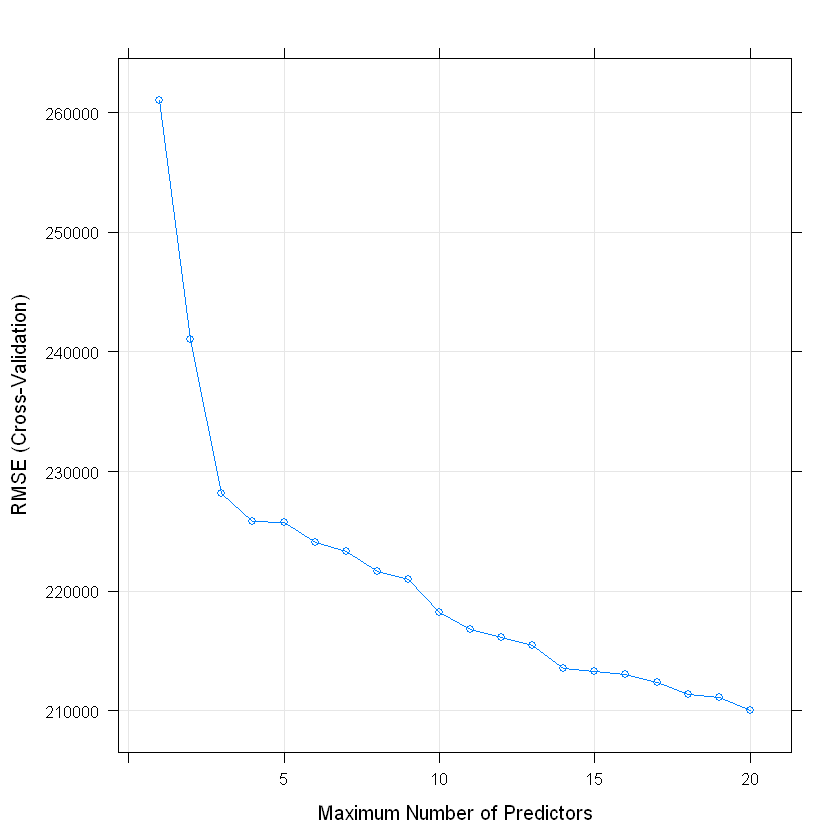

In [185]:
backward_model <- train(price ~ ., data = house_reg,
                       method = "leapBackward",
                       tuneGrid = expand.grid(nvmax = 1:20),
                       trControl = trControl)
plot(backward_model)

**Ridge Regression**

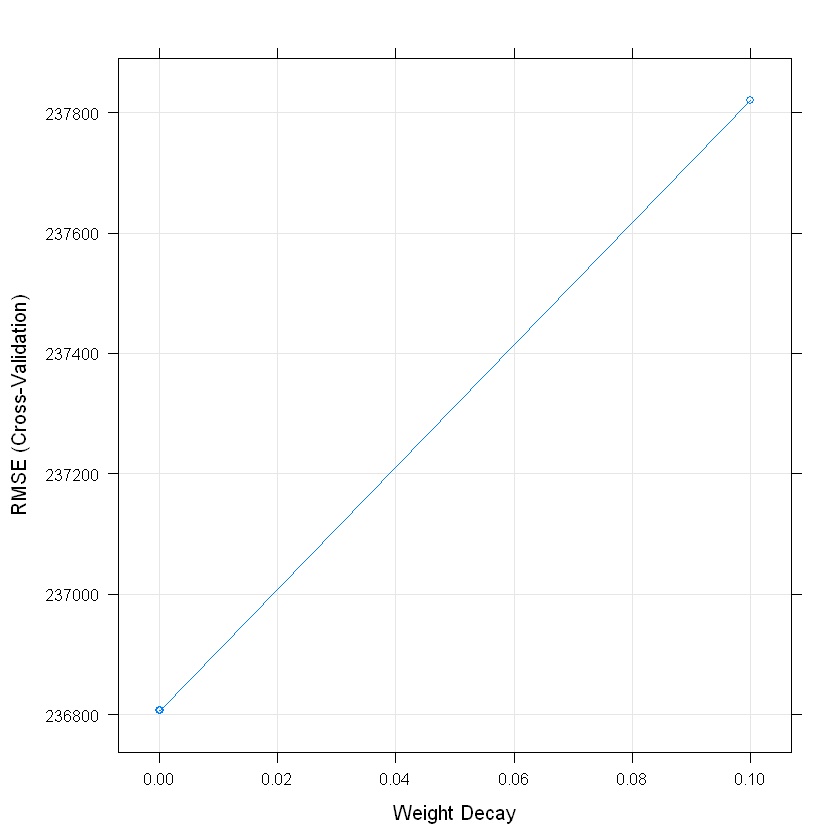

In [186]:
#runs only if vars are numeric. Results in 6 features, possibly limiting 
#the model
house_ridge_lasso <- house_reg %>%
    mutate_if(is.integer, as.numeric) %>% 
    select_if(is.numeric)

ridge_model <- train(price ~ ., data = house_ridge_lasso,
                    method = "ridge",
                    tunegrid = expand.grid(lambda = seq(0, 1, 0.05)),
                    trControl = trControl)
plot(ridge_model)

**Lasso Regression**

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

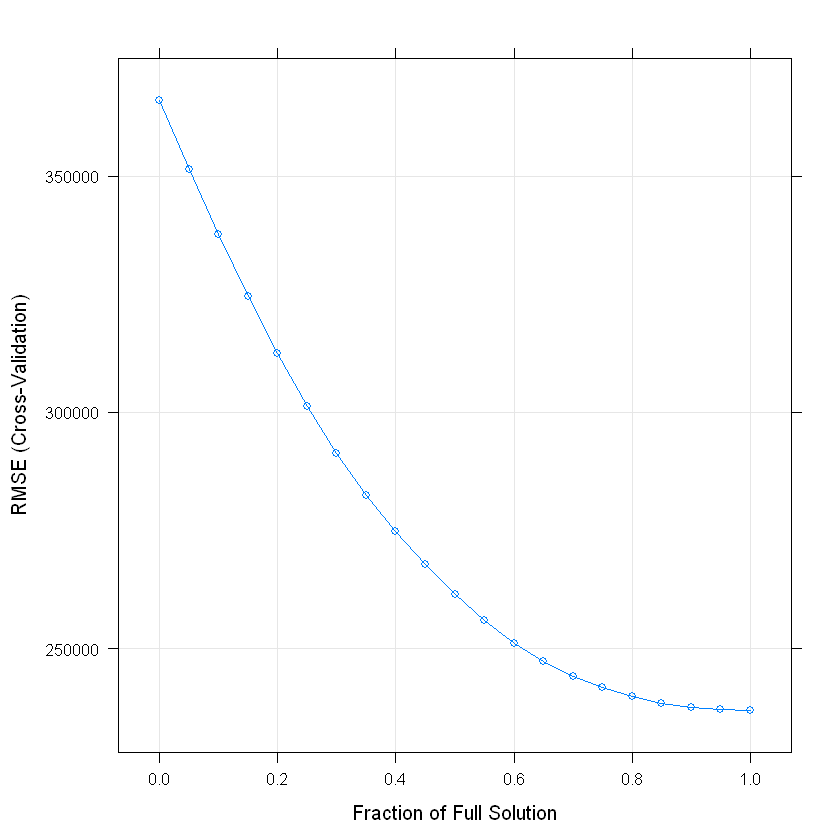

In [187]:
lasso_model <- train(price ~ ., data = house_ridge_lasso,
                    method = "lasso",
                    tuneGrid = expand.grid(fraction = seq(0, 1, 0.05)),
                    trControl = trControl)
plot(lasso_model)

**Bagged Trees**

In [188]:
#use unprocessed data, with factored vars
house_tree <- house_train %>%
    select(1, 4, 5, 11:21, 27:29)

bagged_model <- train(y = house_tree$price,
                     x = select(house_tree, -price),
                     method = 'treebag',
                     trControl = trControl)
bagged_model

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."

Bagged CART 

17289 samples
   16 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 11527, 11525, 11526 
Resampling results:

  RMSE      Rsquared   MAE     
  189501.7  0.7391769  117734.1


**Random Forest**

In [189]:
#optimal mtry is 15, ntrees left at default due to length of time 
rf_model <- train(y = house_tree$price,
                 x = select(house_tree, -price),
                 method = 'rf',
                 tuneGrid = expand.grid(.mtry = 15),
                 trControl = trControl)
rf_model

Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."Warning message:
"Setting row names on a tibble is deprecated."

Random Forest 

17289 samples
   16 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 11526, 11526, 11526 
Resampling results:

  RMSE      Rsquared   MAE    
  138080.6  0.8607928  71889.8

Tuning parameter 'mtry' was held constant at a value of 15

### Model Comparison


Call:
summary.resamples(object = compare)

Models: linear, forward, backward, ridge, lasso, bagged, random_forest 
Number of resamples: 3 

MAE 
                      Min.      1st Qu.       Median         Mean      3rd Qu.
linear        9.072130e-02 9.078789e-02 9.085447e-02 9.108992e-02 9.127423e-02
forward       1.308659e+05 1.342973e+05 1.377286e+05 1.366293e+05 1.395110e+05
backward      1.289009e+05 1.300338e+05 1.311667e+05 1.329252e+05 1.349373e+05
ridge         1.475435e+05 1.491313e+05 1.507191e+05 1.501520e+05 1.514562e+05
lasso         1.489378e+05 1.497782e+05 1.506186e+05 1.501994e+05 1.508301e+05
bagged        1.164681e+05 1.168497e+05 1.172312e+05 1.177341e+05 1.183670e+05
random_forest 7.084515e+04 7.130093e+04 7.175672e+04 7.188980e+04 7.241213e+04
                      Max. NA's
linear        9.169398e-02    0
forward       1.412934e+05    0
backward      1.387080e+05    0
ridge         1.521933e+05    0
lasso         1.510417e+05    0
bagged        1.195029e+05    

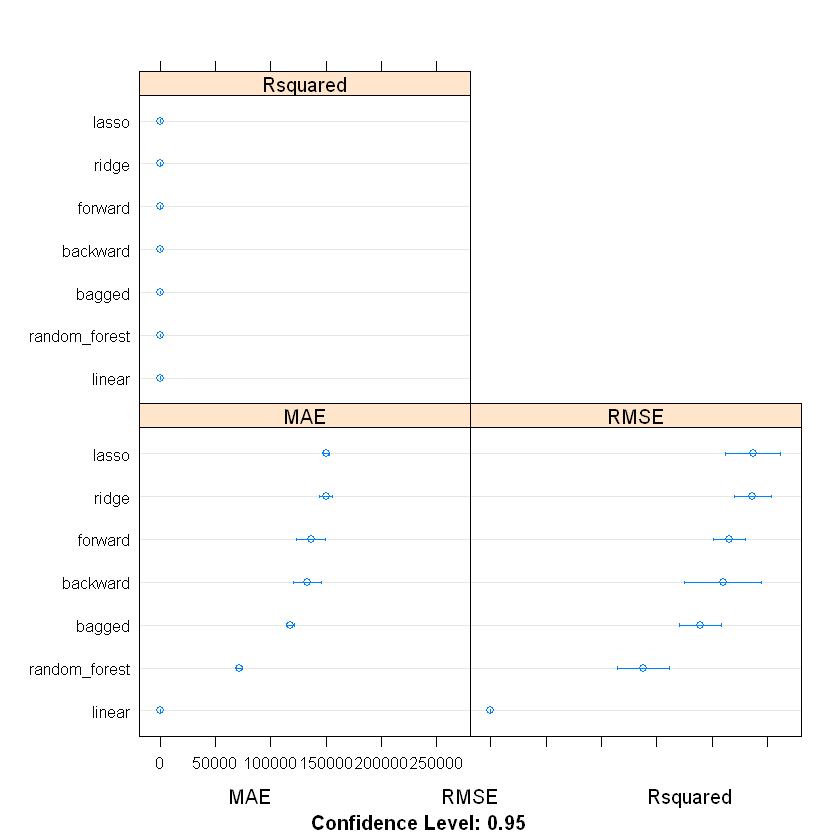

In [190]:
compare <- resamples(list(linear = lm_model,
                         forward = forward_model,
                         backward = backward_model,
                         ridge = ridge_model,
                         lasso = lasso_model,
                         bagged = bagged_model,
                         random_forest = rf_model))
summary(compare)
dotplot(compare)

Using the results of the models and 3-fold cross-validation, we see that random forest outperforms the regression and bagged models. Note that the linear model has wrong error values, but it can be safely assumed that it is similar to the other regression models, i.e. an RMSE of ~ 200,000.

**Selected Model**:

    Random Forest



## Prediction of Home Price

In [192]:
to_predict <- house_tree[0, ]
to_predict[1, ]$sqft_living <- 2000
to_predict[1, ]$sqft_lot <- 3000
to_predict[1, ]$sqft_above <- 1500
to_predict[1, ]$sqft_basement <- 500
to_predict[1, ]$lat <- 47.77
to_predict[1, ]$long <- -122.20
to_predict[1, ]$waterfront_fac <- 0
to_predict[1, ]$view_fac <- 1
to_predict[1, ]$bedrooms_fac <- 4
to_predict[1, ]$bathrooms_fac <- 2
to_predict[1, ]$floors_fac <- 2
to_predict[1, ]$condition_fac <- 4
to_predict[1, ]$grade_fac <- 9
to_predict[1, ]$is_built_recently <- "no"
to_predict[1, ]$is_renovated <- "No"
to_predict[1, ]$month <- 12

to_predict$price <- predict(rf_model, newdata = to_predict)
print(to_predict$price)

[1] 730250.8


The predicted price of a house you might find near my neighborhood is **$730,250.80**.